In [1]:
import os
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table, join, hstack
import astropy.units as u

import scipy.stats as stats

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 24,
    'axes.labelsize': 'large',
    'mathtext.fontset': 'stix'
})

def errJy_to_errABmag(flux_Jy, fluxerr_Jy):
    return -2.5 / (flux_Jy * np.log(10)) * fluxerr_Jy

## GAMA catalog details

In [ ]:
#download GAMA from the database
with fits.open('http://www.gama-survey.org/dr4/data/cat/gkvInputCat/v02/gkvInputCatv02.fits') as cat:
    gkvInputCat = Table(cat[1].data)

with fits.open('http://www.gama-survey.org/dr4/data/cat/StellarMasses/v24/StellarMassesGKVv24.fits') as cat:
    StellarMassesGKV = Table(cat[1].data)

GAMA_mstar_concat = join(gkvInputCat, StellarMassesGKV)

In [285]:
#OR, if the joined catalog exists, import GAMA:
with fits.open('/data2/lsajkov/mpdg/data/GAMA/GAMA_mstars_concat.fits') as hdu:
    GAMA_mstar_concat = Table(hdu[1].data)

Redshifts

In [118]:
#redshift distribution
redshifts = GAMA_mstar_concat[~np.isnan(GAMA_mstar_concat['Z']) &\
                                       (GAMA_mstar_concat['Z'] >= 0)]['Z']

print('= GAMA redshifts =')
print('counting non-nan ')
print('and >= 0 only')
print(f'total:\t{len(redshifts)}')
print(f'min:\t{np.min(redshifts):.3f}')
print(f'max:\t{np.max(redshifts):.3f}')
print(f'mean:\t{np.mean(redshifts):.3f}')
print(f'median:\t{np.median(redshifts):.3f}')
print(f'std:\t{np.std(redshifts):.3f}')
print('==================')

= GAMA redshifts =
counting non-nan 
and >= 0 only
total:	364119
min:	0.000
max:	7.023
mean:	0.264
median:	0.219
std:	0.291


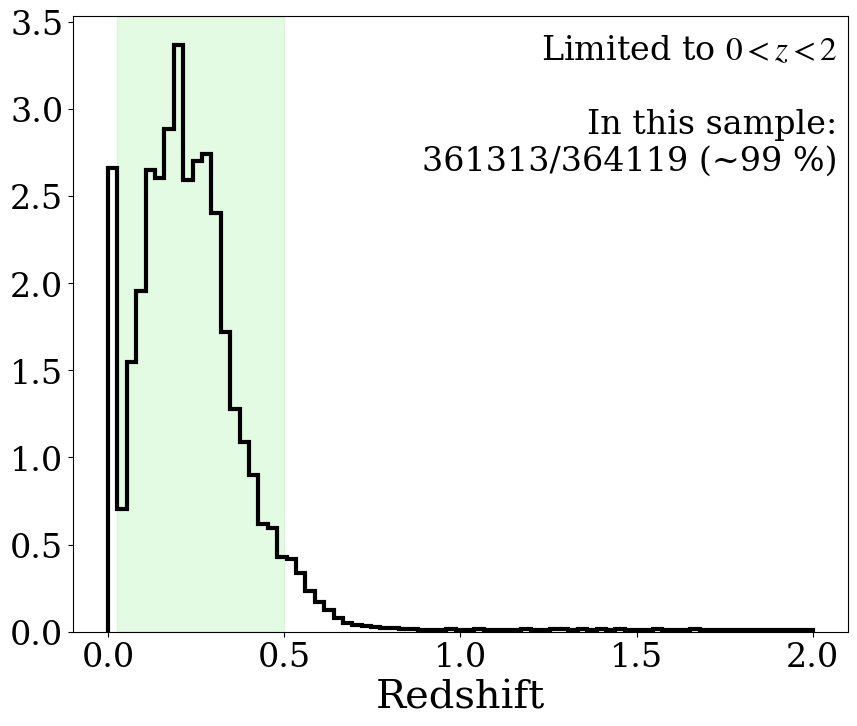

In [119]:
fig = plt.figure(figsize = (10, 8))
ax  = fig.add_subplot()

GAMA_redshift_subset = redshifts[(redshifts >= 0.) &\
                       (redshifts < 2)]

ax.hist(GAMA_redshift_subset,
        bins = 75, histtype = 'step',
        linewidth = 3, color = 'black', density = True)

ax.set_xlabel('Redshift')
ax.text(0.45, 0.75,
        f'Limited to $0 < z < 2$\n\nIn this sample:\n{len(GAMA_redshift_subset)}/{len(GAMA_redshifts)} (~{int(100 * len(GAMA_redshift_subset)/len(GAMA_redshifts))} %)',
        transform = ax.transAxes,
        ma = 'right')

ax.axvspan(0.025, 0.5, color = 'lightgreen', alpha = 0.25)

Magnitude distribution

In [144]:
g_snr = GAMA_mstar_concat['flux_gt']/GAMA_mstar_concat['flux_err_gt']
g_mag = GAMA_mstar_concat['flux_gt'] * u.Jy
g_mag = g_mag.to(u.ABmag).value

r_snr = GAMA_mstar_concat['flux_rt']/GAMA_mstar_concat['flux_err_rt']
r_mag = GAMA_mstar_concat['flux_rt'] * u.Jy
r_mag = r_mag.to(u.ABmag).value

/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/var/tmp/lsajkov/ipykernel_1193969/3428203710.py:3: RuntimeWarning: divide by zero encountered in divide
  g_snr = GAMA_mstar_concat['flux_gt']/GAMA_mstar_concat['flux_err_gt']


Text(0.5, 0, 'Magnitude ($r$ or $g$)')

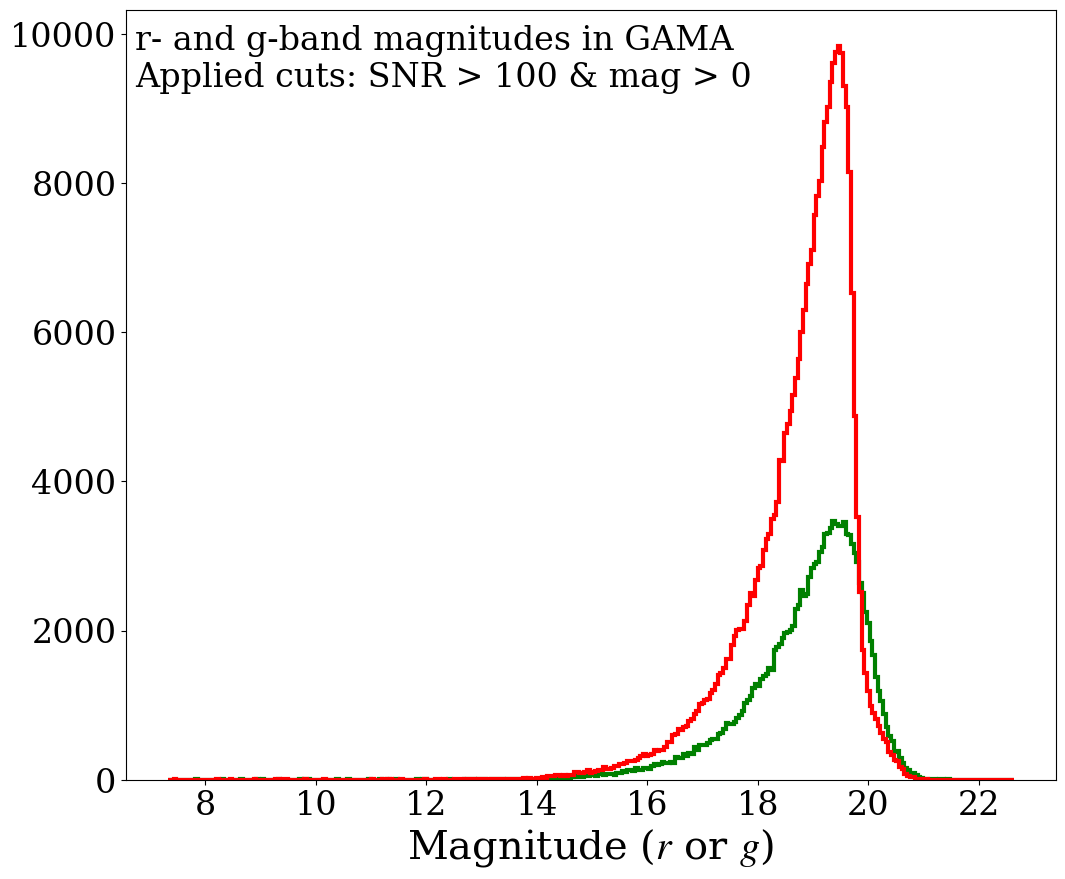

In [168]:
fig = plt.figure(figsize = (12, 10))
ax  = fig.add_subplot()

snr_thresh = 100

bins = ax.hist(g_mag[(g_mag > 0) & (g_snr > snr_thresh)],
        bins = 'auto',
        histtype = 'step', color = 'green',
        linewidth = 3)
ax.hist(r_mag[(r_mag > 0) & (r_snr > snr_thresh)],
        bins = bins[1], 
        histtype = 'step', color = 'red',
        linewidth = 3)

ax.text(0.01, 0.9,
        f'r- and g-band magnitudes in GAMA\nApplied cuts: SNR > {snr_thresh} & mag > 0',
        transform = ax.transAxes)

ax.set_xlabel('Magnitude ($r$ or $g$)')

R-band effective fwhm radius

In [276]:
#the approximate area defined by the fwhm is 76%
#the area within R50 is 50%
#therefore, to scale R50 up to Rfwhm, we must scale up by
r50_to_fwhm_scale_factor = np.sqrt(0.76/0.50)

In [277]:
r50_to_fwhm_scale_factor

1.2328828005937953

In [2]:
def gaussian(x, mean, std):
    return 1 / (np.sqrt(2 * np.pi * std**2)) * np.exp(-(x - mean) ** 2/(2 * std ** 2))

In [283]:
std = 1

xs, ys = np.meshgrid(np.linspace(-3, 3, 501),
                    np.linspace(-3, 3, 501))
gauss2d = gaussian(xs, 0, std) * gaussian(ys, 0, std)
gauss2d /= np.sum(gauss2d)

fwhm_idx  = np.abs(gauss2d - np.max(gauss2d)/2) < 1e-3
fwhm_ring = np.where(fwhm_idx, True, np.nan)
fwhm_radius_x = (np.max(xs[fwhm_idx]) - np.min(xs[fwhm_idx])) / 2
fwhm_radius_y = (np.max(ys[fwhm_idx]) - np.min(ys[fwhm_idx])) / 2
fwhm_area = np.where(gauss2d > np.max(gauss2d)/2,
                    True, np.nan) 

thresh = np.max(gauss2d) * 0.95
while np.sum(gauss2d[gauss2d > thresh]) < 0.5:
    thresh -= 1e-7
half_light_idx  = gauss2d > thresh
half_light_radius_x = (np.max(xs[half_light_idx]) - np.min(xs[half_light_idx])) / 2
half_light_radius_y = (np.max(ys[half_light_idx]) - np.min(ys[half_light_idx])) / 2
half_light_ring = np.where(gauss2d > thresh, True, np.nan)

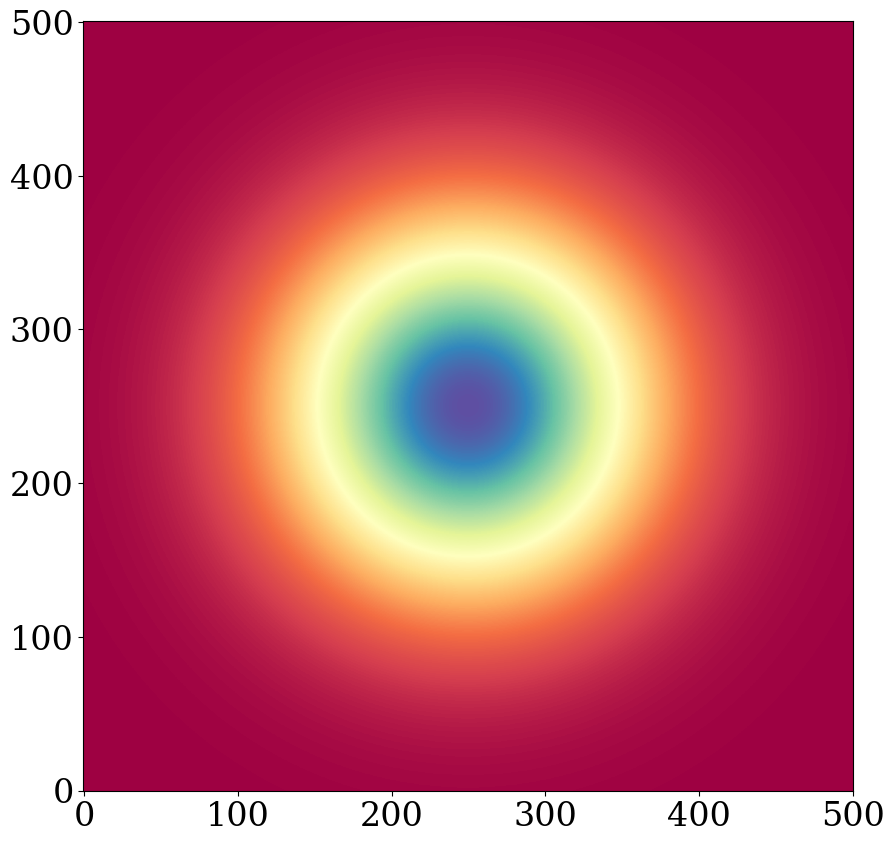

In [284]:
fig = plt.figure(figsize = (10, 10))
ax  = fig.add_subplot()

ax.imshow(gauss2d, origin = 'lower', cmap = 'Spectral')

In [280]:
fwhm_radius_x/r50_to_fwhm_scale_factor

1.8493242008906938

In [281]:
half_light_radius_x

1.08

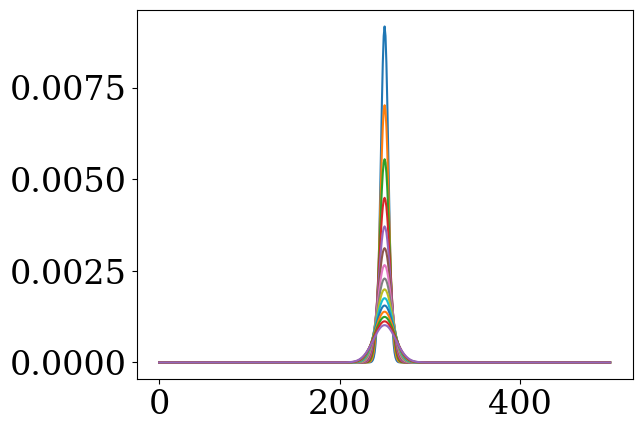

In [273]:
half_light_radii = []
fwhm_radii = []

for std in np.linspace(0.5, 1.5, 15):
    xs, ys = np.meshgrid(np.linspace(-30, 30, 501),
                        np.linspace(-30, 30, 501))
    gauss2d = gaussian(xs, 0, std) * gaussian(ys, 0, std)
    gauss2d /= np.sum(gauss2d)

    fwhm_idx  = np.abs(gauss2d - np.max(gauss2d)/2) < 1e-3
    # fwhm_ring = np.where(fwhm_idx, True, np.nan)
    fwhm_radius_x = (np.max(xs[fwhm_idx]) - np.min(xs[fwhm_idx])) / 2
    # fwhm_radius_y = (np.max(ys[fwhm_idx]) - np.min(ys[fwhm_idx])) / 2
    # fwhm_area = np.where(gauss2d > np.max(gauss2d)/2,
    #                     True, np.nan) 

    thresh = np.max(gauss2d) * 0.95
    while np.sum(gauss2d[gauss2d > thresh]) < 0.5:
        thresh -= 1e-7
    half_light_idx  = gauss2d > thresh
    half_light_radius_x = (np.max(xs[half_light_idx]) - np.min(xs[half_light_idx])) / 2
    # half_light_radius_y = (np.max(ys[half_light_idx]) - np.min(ys[half_light_idx])) / 2
    # half_light_ring = np.where(gauss2d > thresh, True, np.nan)

    half_light_radii.append(half_lighthttp://desi.ibl.gov/_radius_x)
    fwhm_radii.append(fwhm_radius_x)
    
    plt.plot(gauss2d[250])

half_light_radii = np.array(half_light_radii)
fwhm_radii = np.array(fwhm_radii)

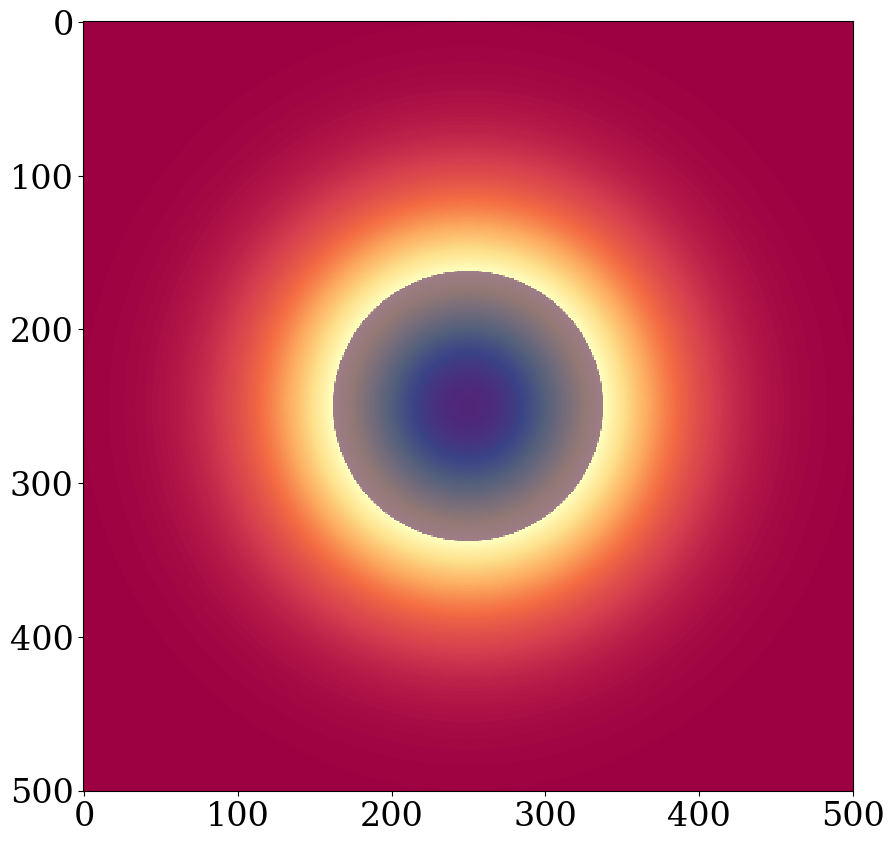

In [250]:
fig = plt.figure(figsize = (10, 10))
ax  = fig.add_subplot()

ax.imshow(gauss2d, origin = 'lower', cmap = 'Spectral')

# ax.imshow(fwhm_ring, origin = 'lower')

# thresh = np.max(gauss2d) * 0.95
# while np.sum(gauss2d[gauss2d > thresh]) < 0.5:
#     thresh -= 1e-7
# half_light_ring = np.where(gauss2d > thresh, True, np.nan)

# ax.imshow(half_light_ring, cmap = 'viridis', alpha = 0.3)
# ax.imshow(fwhm_area, cmap = 'viridis', alpha = 0.3)

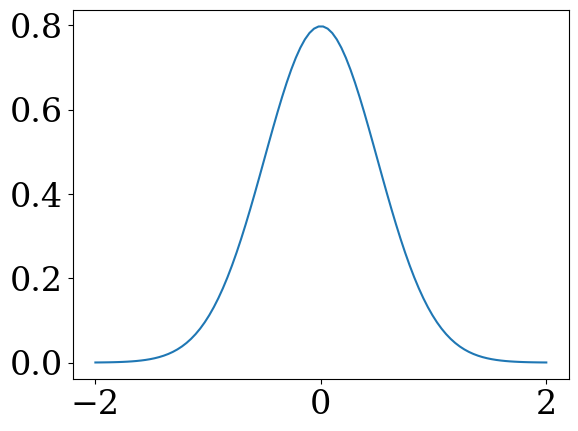

In [5]:
plt.plot(np.linspace(-2, 2, 100),
         gaussian(np.linspace(-2, 2, 100), 0, 0.5))

## GAMA Science Cat + Stellar Masses
\+ SOM catalog

In [2]:
with fits.open('/data2/lsajkov/mpdg/data/GAMA/gkvScienceCatv02.fits') as cat:
    ScienceCat = Table(cat[1].data)

In [3]:
#redshift distribution
redshifts = ScienceCat[~np.isnan(ScienceCat['Z']) &\
                                (ScienceCat['Z'] >= 0)]['Z']

print('= GAMA redshifts =')
print('counting non-nan ')
print('and >= 0 only')
print(f'total:\t{len(redshifts)}')
print(f'min:\t{np.min(redshifts):.3f}')
print(f'max:\t{np.max(redshifts):.3f}')
print(f'mean:\t{np.mean(redshifts):.3f}')
print(f'median:\t{np.median(redshifts):.3f}')
print(f'std:\t{np.std(redshifts):.3f}')
print('==================')

= GAMA redshifts =
counting non-nan 
and >= 0 only
total:	359583
min:	-0.000
max:	6.972
mean:	0.256
median:	0.217
std:	0.273


Text(0.385, 0.035, '0.4')

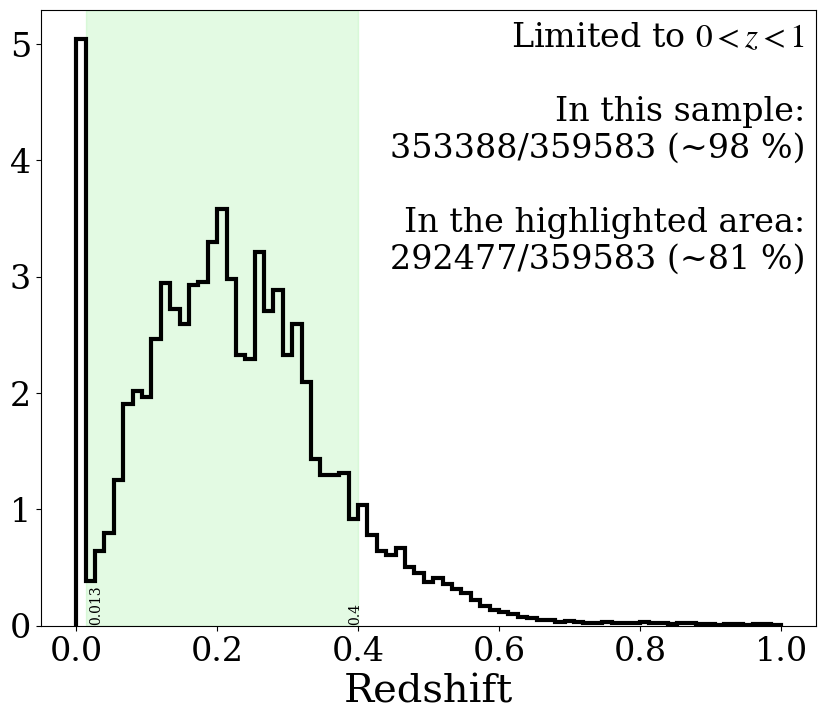

In [36]:
fig = plt.figure(figsize = (10, 8))
ax  = fig.add_subplot()

redshift_idx = (redshifts >= 0.) & (redshifts < 1)
redshift_subset = redshifts[redshift_idx]


bins = ax.hist(redshift_subset,
        bins = 75, histtype = 'step',
        linewidth = 3, color = 'black', density = True)

highlight_idx = (redshifts >= bins[1][1]) & (redshifts <= 0.4)

ax.set_xlabel('Redshift')

plot_text = 'Limited to $0 < z < 1$\n\n' +\
           f'In this sample:\n{np.sum(redshift_idx)}/{len(redshift_idx)} (~{int(100 * np.sum(redshift_idx)/len(redshift_idx))} %)\n\n' +\
           f'In the highlighted area:\n{np.sum(highlight_idx)}/{len(highlight_idx)} (~{int(100 * np.sum(highlight_idx)/len(highlight_idx))} %)'

ax.text(0.45, 0.58,
        plot_text,
        transform = ax.transAxes,
        ma = 'right')

ax.axvspan(bins[1][1], 0.4, color = 'lightgreen', alpha = 0.25)

ax.text(bins[1][1] + 5e-3, 0.035, f'{bins[1][1]:.3f}', fontsize = 10, rotation = 90)
ax.text(0.4 - 15e-3, 0.035, 0.4, fontsize = 10, rotation = 90)

In [ ]:
r_mag = (ScienceCat['flux_rt'] * u.Jansky).to(u.ABmag).value
r_snr = ScienceCat['flux_rt']/ScienceCat['flux_err_rt']

g_mag = (ScienceCat['flux_gt'] * u.Jansky).to(u.ABmag).value
g_snr = ScienceCat['flux_gt']/ScienceCat['flux_err_gt']

u_mag = (ScienceCat['flux_ut'] * u.Jansky).to(u.ABmag).value
u_snr = ScienceCat['flux_ut']/ScienceCat['flux_err_ut']

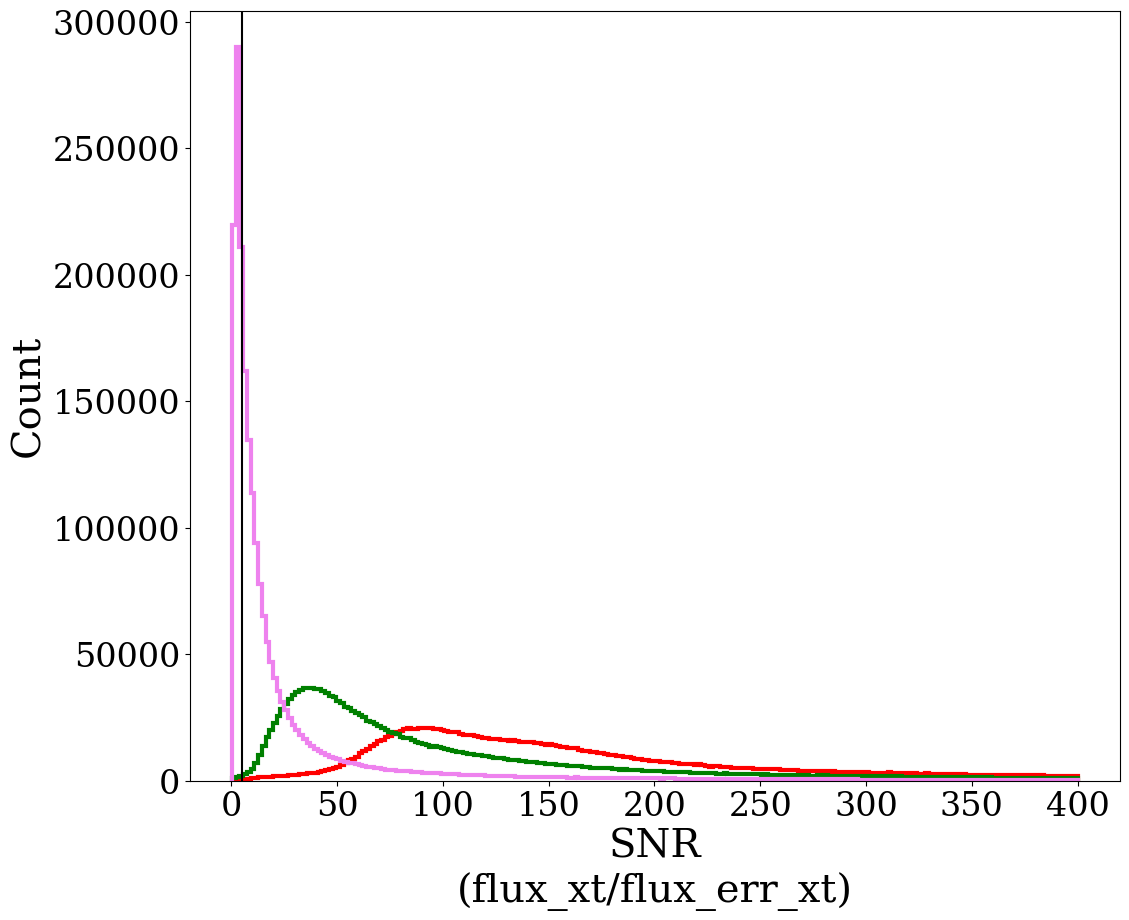

In [58]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

cutoff = 400

bins = ax.hist(r_snr[r_snr < cutoff], bins = 'auto',
               histtype = 'step', color = 'red',
               linewidth = 3)[1]

ax.hist(g_snr[g_snr < cutoff],
        bins = bins,
        histtype = 'step', color = 'green', linewidth = 3)

ax.hist(u_snr[u_snr < cutoff],
        bins = bins,
        histtype = 'step', color = 'violet', linewidth = 3)

ax.set_xlabel('SNR\n(flux_xt/flux_err_xt)')
ax.set_ylabel('Count')

ax.axvline(5, color = 'black')

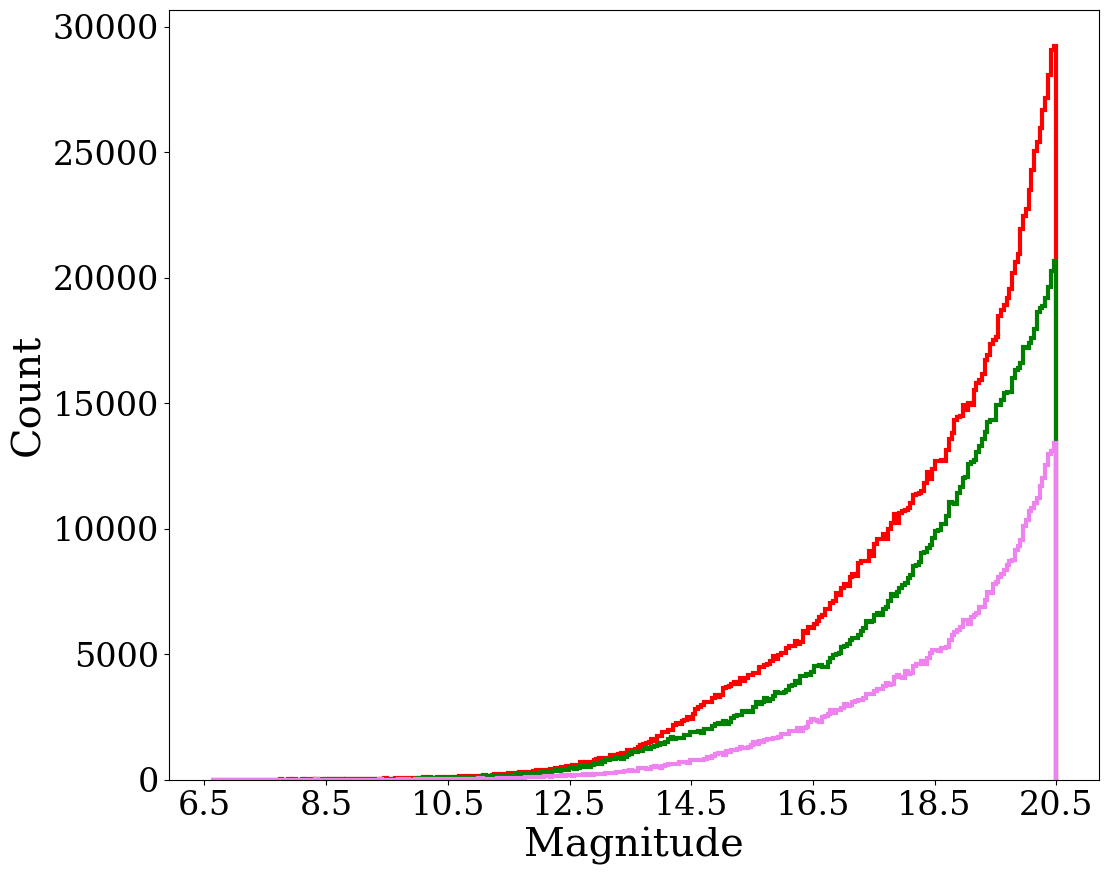

In [69]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

snr_thresh = 5
snr_mask = (u_snr > snr_thresh) &\
           (g_snr > snr_thresh) &\
           (r_snr > snr_thresh)

bins = ax.hist(r_mag[snr_mask],
               bins = 'auto', histtype = 'step',
               color = 'red', linewidth = 3)[1]

ax.hist(g_mag[snr_mask],
        bins = bins, histtype = 'step',
        color = 'green', linewidth = 3)

ax.hist(u_mag[snr_mask],
        bins = bins, histtype = 'step',
        color = 'violet', linewidth = 3)

ax.set_xlabel('Magnitude')
ax.set_ylabel('Count')

ax.set_xticks(np.arange(6.5, 21.5, 2))

In [71]:
redshift_mask = (ScienceCat['Z'] >= 0.) & (ScienceCat['Z'] < 1)

snr_thresh = 5
snr_mask = (u_snr > snr_thresh) &\
           (g_snr > snr_thresh) &\
           (r_snr > snr_thresh)

total_mask = redshift_mask & snr_mask

SOM-ready color catalog

In [2]:
with fits.open('/data2/lsajkov/mpdg/data/GAMA/gkvScienceCatv02.fits') as cat:
    ScienceCat = Table(cat[1].data)

with fits.open('/data2/lsajkov/mpdg/data/GAMA/StellarMassesGKVv24.fits') as cat:
    StellarMassesGKV = Table(cat[1].data)
    
joined_ScienceCat_StellarMassesGKV = join(ScienceCat, StellarMassesGKV)

In [18]:
#construct SOM catalog columns
cat = joined_ScienceCat_StellarMassesGKV

def errJy_to_errABmag(flux_Jy, fluxerr_Jy):
    return -2.5 / (flux_Jy * np.log(10)) * fluxerr_Jy

uberID = cat['uberID']

r_mag = (cat['flux_rt'] * u.Jansky).to(u.ABmag).value
r_mag_err = errJy_to_errABmag(cat['flux_rt'], cat['flux_err_rt'])
r_snr = cat['flux_rt']/cat['flux_err_rt']

g_mag = (cat['flux_gt'] * u.Jansky).to(u.ABmag).value
g_mag_err = errJy_to_errABmag(cat['flux_gt'], cat['flux_err_gt'])
g_snr = cat['flux_gt']/cat['flux_err_gt']

u_mag = (cat['flux_ut'] * u.Jansky).to(u.ABmag).value
u_mag_err = errJy_to_errABmag(cat['flux_ut'], cat['flux_err_ut'])
u_snr = cat['flux_ut']/cat['flux_err_ut']

i_mag = (cat['flux_it'] * u.Jansky).to(u.ABmag).value
i_mag_err = errJy_to_errABmag(cat['flux_it'], cat['flux_err_it'])
i_snr = cat['flux_it']/cat['flux_err_it']

ug_color     = u_mag - g_mag
ug_color_err = np.sqrt(u_mag_err ** 2 + g_mag_err ** 2)

gr_color     = g_mag - r_mag
gr_color_err = np.sqrt(g_mag_err ** 2 + r_mag_err ** 2)

ur_color     = u_mag - r_mag
ur_color_err = np.sqrt(u_mag_err ** 2 + r_mag_err ** 2)

ri_color     = r_mag - i_mag
ri_color_err = np.sqrt(r_mag_err ** 2 + i_mag_err ** 2)

log_mstar     = cat['logmstar']
log_mstar_err = cat['dellogmstar']

R50 = cat['R50']

redshift = cat['Z']

/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/var/tmp/lsajkov/ipykernel_3038346/2275796733.py:15: RuntimeWarning: divide by zero encountered in divide
  g_snr = cat['flux_gt']/cat['flux_err_gt']
/var/tmp/lsajkov/ipykernel_3038346/2275796733.py:19: RuntimeWarning: divide by zero encountered in divide
  u_snr = cat['flux_ut']/cat['flux_err_ut']
/var/tmp/lsajkov/ipykernel_3038346/2275796733.py:23: RuntimeWarning: divide by zero encountered in divide
  i_snr = cat['flux_it']/cat['flux_err_it']


In [19]:
#quality cuts
snr_thresh = 5
snr_cut = (r_snr >= snr_thresh) &\
          (g_snr >= snr_thresh) &\
          (u_snr >= snr_thresh) &\
          (i_snr >= snr_thresh)

redshift_cut = (redshift >= 0) & (redshift < 1)

color_lo = -3
color_hi = 3
color_cut = (gr_color > color_lo) & (gr_color < color_hi) &\
            (ug_color > color_lo) & (ug_color < color_hi) &\
            (ur_color > color_lo) & (ur_color < color_hi) &\
            (ri_color > color_lo) & (ri_color < color_hi)

log_mstar_lo = 6
log_mstar_hi = 12
log_mstar_cut = (log_mstar > log_mstar_lo) & (log_mstar < log_mstar_hi)

R50_cut = R50 < 10

In [20]:
#define primary targeting region
def gr_color_condition(gr_color, gr_color_err,
               r_mag):
    
    return (gr_color - gr_color_err + 0.06 * (r_mag - 14)) < 0.9


def surf_bright_condition(surf_bright_r, surf_bright_r_err,
                                 r_mag):
    
    return (surf_bright_r + surf_bright_r_err\
            - 0.7 * (r_mag - 14)) > 18.5

In [21]:
prt_gr_color_cut = gr_color_condition(gr_color,
                                      gr_color_err,
                                      r_mag)

prt_mag_cut = r_mag > 18

In [22]:
total_cut = snr_cut &\
            redshift_cut &\
            color_cut &\
            log_mstar_cut &\
            R50_cut &\
            prt_gr_color_cut &\
            prt_mag_cut

In [23]:
print('Grand total of cuts:')
print(f'{np.sum(total_cut)}/{len(total_cut)} (~{int(100 * np.sum(total_cut)/len(total_cut))}%)')

Grand total of cuts:
49774/361748 (~13%)


In [25]:
GAMA_SOM_training_catalog = Table([uberID[total_cut],
                                    r_mag[total_cut],
                                    r_mag_err[total_cut],
                                    g_mag[total_cut],
                                    g_mag_err[total_cut],
                                    u_mag[total_cut],
                                    u_mag_err[total_cut],
                                    i_mag[total_cut],
                                    i_mag_err[total_cut],
                                    gr_color[total_cut],
                                    gr_color_err[total_cut],
                                    ug_color[total_cut],
                                    ug_color_err[total_cut],
                                    ur_color[total_cut],
                                    ur_color_err[total_cut],
                                    ri_color[total_cut],
                                    ri_color_err[total_cut],                                    redshift[total_cut],
                                    log_mstar[total_cut],
                                    log_mstar_err[total_cut],
                                    R50[total_cut]],
                           names = ['ID',
                                    'r_mag', 'r_mag_err',
                                    'g_mag', 'g_mag_err',
                                    'u_mag', 'u_mag_err',
                                    'i_mag', 'i_mag_err',                                    
                                    'gr_col', 'gr_col_err',
                                    'ug_col', 'ug_col_err', 
                                    'ur_col', 'ur_col_err',
                                    'ri_col', 'ri_col_err',
                                    'redshift',
                                    'log_mstar', 'log_mstar_err',
                                    'half_light_radius'])

In [26]:
GAMA_SOM_training_catalog.write('/data2/lsajkov/mpdg/data_products/GAMA/GAMA_SOM_training_catalog_08Jul24.fits',
                                overwrite = True)

### Log of training catalog parameters:

**July 4, 2024**:<br>
$\mathrm{SNR} > 5$,<br>
$0<z<1$,<br>
$-3<color<3$,<br>
$6<\log(M_*)<12$,<br>
$R_{50}<10$<br>
\+ Everything is within the primary targeting region as defined **only** in Thornton+23 condition (1)

**July 5, 2024**:<br>
$\mathrm{SNR} > 5$,<br>
$0<z<1$,<br>
$-3<color<3$,<br>
$6<\log(M_*)<12$,<br>
$R_{50}<10$<br>
\+ Everything is within the primary targeting region as defined **only** in Thornton+23 condition (1)

**July 8, 2024**:<br>
*Using observed magnitudes, rather than restframe* <br>
$\mathrm{SNR} > 5$,<br>
$0<z<1$,<br>
$-3<color<3$,<br>
$6<\log(M_*)<12$,<br>
$R_{50}<10$<br>
\+ Everything is within the primary targeting region as defined **only** in Thornton+23 condition (1)

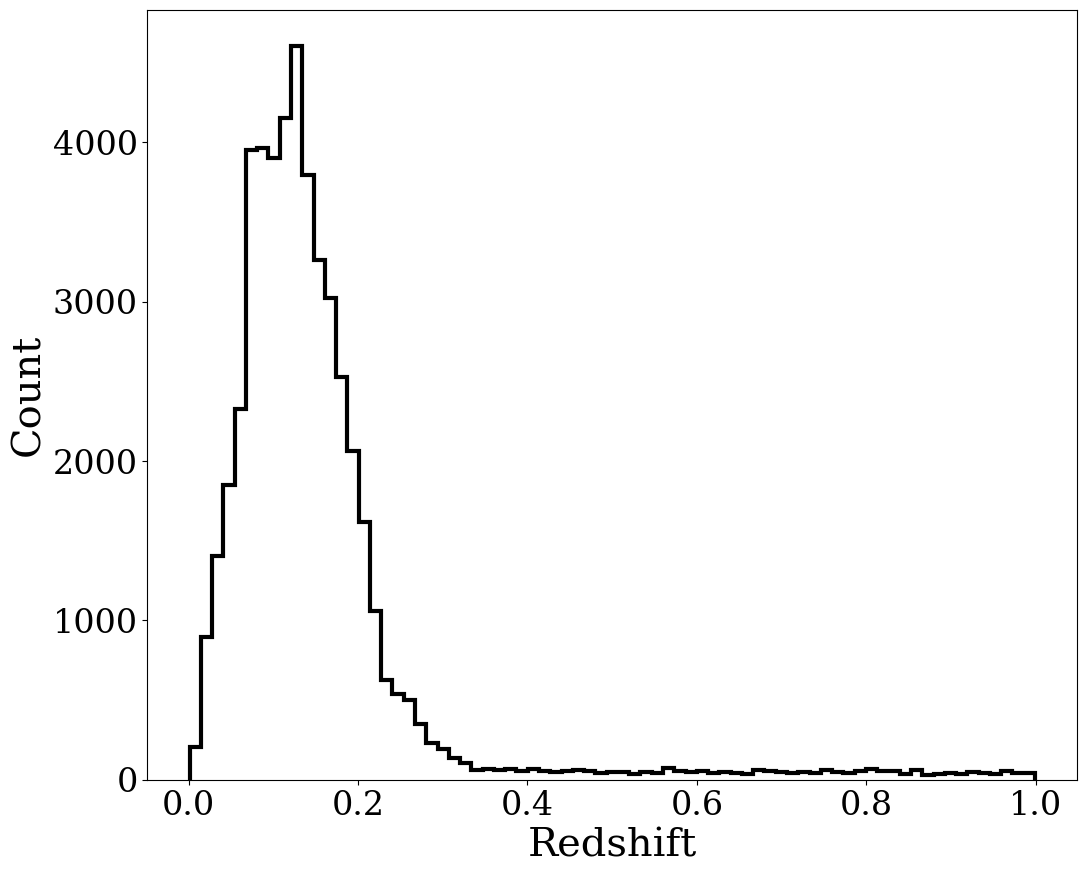

In [44]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(GAMA_SOM_training_catalog['redshift'], bins = 75,
        histtype = 'step', color = 'black', linewidth = 3)

ax.set_xlabel('Redshift')
ax.set_ylabel('Count')

fig.savefig('/data2/lsajkov/mpdg/figures/primary_targeting_region/GAMA_ptr_redshift_08jul2024.png',
            bbox_inches = 'tight')

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/tmp/lsajkov/ipykernel_3038346/3332503233.py:7: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\log(M_*/M_{\odot})$')


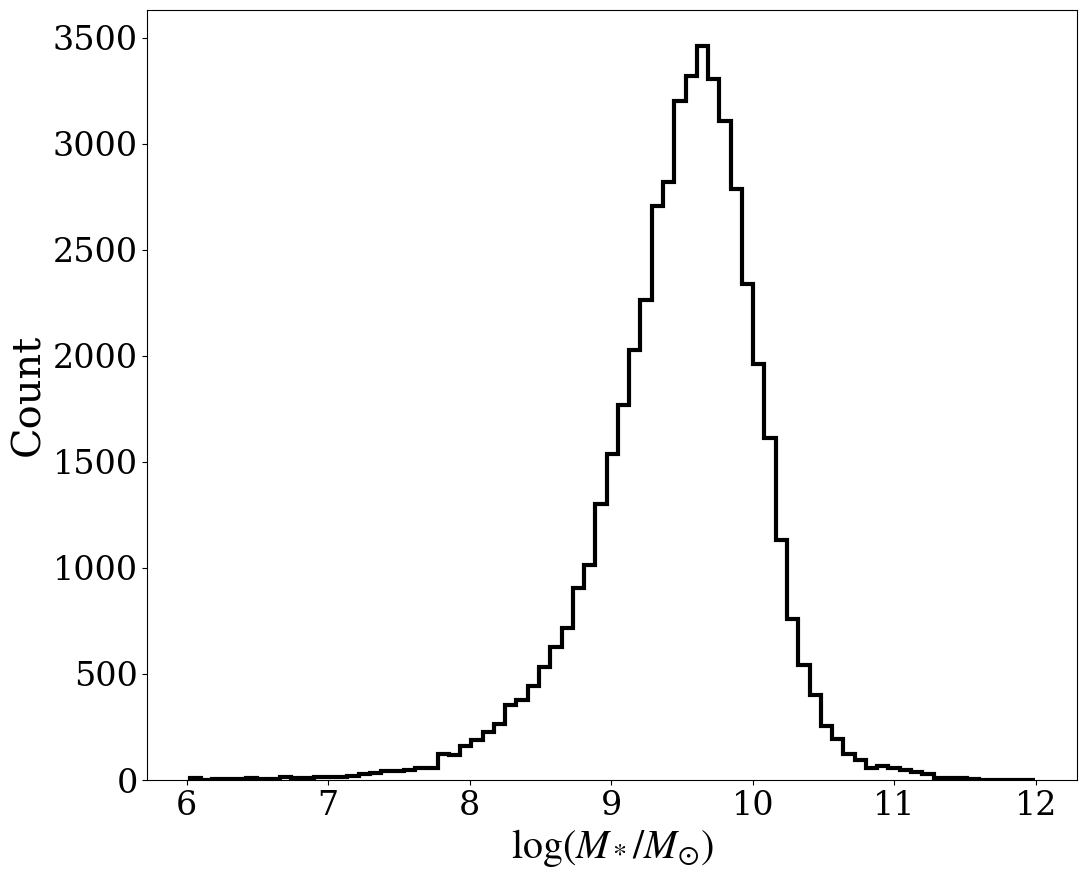

In [46]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(GAMA_SOM_training_catalog['log_mstar'], bins = 75,
        histtype = 'step', color = 'black', linewidth = 3)

ax.set_xlabel('$\log(M_*/M_{\odot})$')
ax.set_ylabel('Count')

fig.savefig('/data2/lsajkov/mpdg/figures/primary_targeting_region/GAMA_ptr_logmstar_08jul2024.png',
            bbox_inches = 'tight')

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\o'
/var/tmp/lsajkov/ipykernel_3038346/2832370033.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$g_{\mathrm{abs}}-r_{\mathrm{abs}}$')
/var/tmp/lsajkov/ipykernel_3038346/2832370033.py:31: SyntaxWarning: invalid escape sequence '\o'
  fig.colorbar(mappable = hb, label = 'Median log$(M_*/M_{\odot})$')


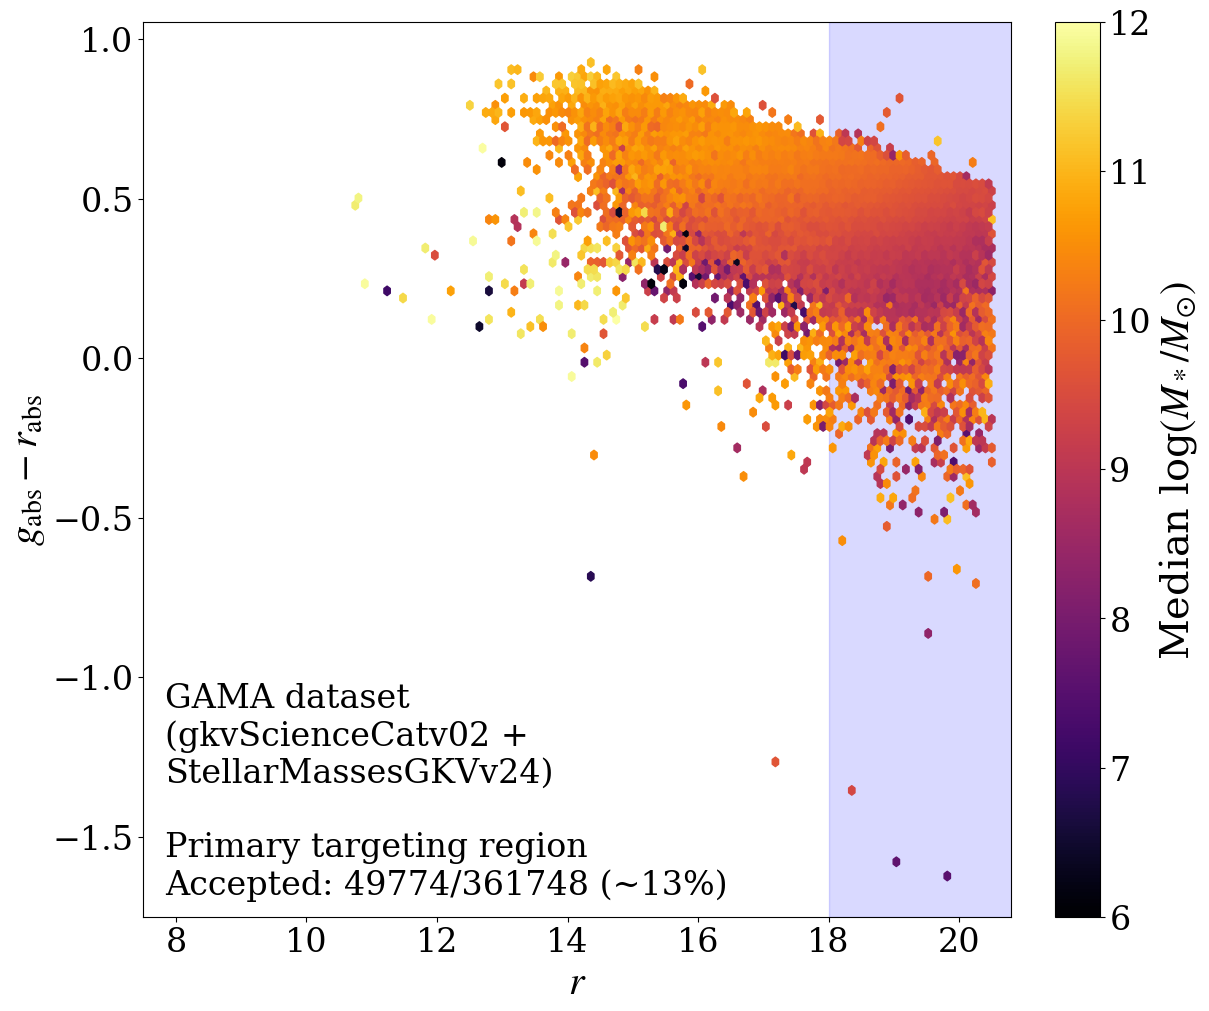

In [36]:
fig = plt.figure(figsize = (12, 10), constrained_layout = True)
ax  = fig.add_subplot()

plot_cut = snr_cut &\
           redshift_cut &\
           color_cut &\
           log_mstar_cut &\
           R50_cut &\
           prt_gr_color_cut

hb  = ax.hexbin(r_mag[plot_cut],
                gr_color[plot_cut],
                log_mstar[plot_cut],
                reduce_C_function = np.median,
                cmap = 'inferno',
                vmin = 6, vmax = 12)

plot_text = 'GAMA dataset\n(gkvScienceCatv02 +\nStellarMassesGKVv24)\n\n' +\
            'Primary targeting region\n' +\
           f'Accepted: {np.sum(total_cut)}/{len(total_cut)} (~{int(100 * np.sum(total_cut)/len(total_cut))}%)'

ax.text(0.025, 0.025, plot_text, transform = ax.transAxes)

ax.set_xlabel('$r$')
ax.set_ylabel('$g_{\mathrm{abs}}-r_{\mathrm{abs}}$')

ax.axvspan(18, 21, color = 'blue', alpha = 0.15, zorder = 0)

ax.set_xlim(7.5, 20.8)

fig.colorbar(mappable = hb, label = 'Median log$(M_*/M_{\odot})$')

fig.savefig('/data2/lsajkov/mpdg/figures/primary_targeting_region/GAMA_primary_targ_reg_gr_col_08jul2024.png',
            dpi = 150, bbox_inches = 'tight')